In [87]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn import decomposition
import sys
import torch

sys.path.append(os.path.join(os.getenv("HOME"), "RNN_Manifold/"))
from manifold_encoder_decoder import s1_direct_product_decoder, geometry_util, s1_direct_product_dimension_detecting_decoder

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


First, load the data. In this notebook I am using data from Mouse 28-140313 (same as nature paper fig.2). The only preprocessing that has been applied is a smoothing of spikes to produce rates.

In [69]:
data_dir = "/home/trevor/manifold_test_data/experimental_ring_data"
data = np.squeeze(np.load(os.path.join(data_dir, "encoded_points.npy")))
angles = np.squeeze(np.load(os.path.join(data_dir, "true_phases.npy")))

Linear dimensionality reduction helps to mitigate the effects of bottlenecking in the model

In [70]:
pca_instance = decomposition.PCA(n_components=10)
proj_data = pca_instance.fit_transform(np.sqrt(data))
normed_rates = proj_data/np.mean(np.abs(proj_data))

Fit the manifold

In [71]:
decoder_hidden_size = 1000
encoder_hidden_size = int(1.5 * decoder_hidden_size)
decoder_n_hidden = 2
encoder_n_hidden = decoder_n_hidden

In [72]:
encoder, decoder = s1_direct_product_decoder.train(data=normed_rates, manifold_dim=1, device=device,
                                                   n_training_iterations=500, decoder_weight=10, order_red_weight=0.1, batch_size=50, encoder_hidden_dim=encoder_hidden_size, encoder_n_hidden=encoder_n_hidden, decoder_hidden_dim=decoder_hidden_size, decoder_n_hidden=decoder_n_hidden, layer_nonlin=torch.nn.Tanh)


/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 2.2510483264923096, distance cost: 0.0015642731450498104, order reduction: 0.004771414678543806
iteration: 3, decoding loss: 1.5892337560653687, distance cost: 0.03819168731570244, order reduction: 0.004453246481716633
iteration: 5, decoding loss: 1.1902648210525513, distance cost: 0.01093843299895525, order reduction: 0.0020060755778104067
iteration: 7, decoding loss: 1.0469796657562256, distance cost: 0.021691573783755302, order reduction: 0.0018701263470575213
iteration: 10, decoding loss: 0.9583538770675659, distance cost: 0.0015335807111114264, order reduction: 0.0018733722390607
iteration: 11, decoding loss: 0.8920888304710388, distance cost: 0.010143128223717213, order reduction: 0.0019972817972302437
iteration: 15, decoding loss: 0.8380191922187805, distance cost: 0.010871394537389278, order reduction: 0.002240249188616872
iteration: 16, decoding loss: 0.7932378649711609, distance cost: 0.008188074454665184, order reduction: 0.0023883481044322252
it

We can do some random projections of the results

In [73]:
n_projections = 6
embed_dim = np.shape(normed_rates)[1]
random_projections = np.random.normal(0, 1, (n_projections, 2, embed_dim))
col_norm = np.einsum("ijk, ijk -> ik", random_projections, random_projections)
normed_proj = np.einsum("ijk, ik -> ijk", random_projections, 1/np.sqrt(col_norm))
projected_data = np.einsum("bk, ijk -> bij", normed_rates, normed_proj)

In [74]:
test_angles = np.linspace(start=0, stop=2 * np.pi, num=1000)
test_points = np.expand_dims(geometry_util.angles_to_ring(test_angles), -2)
with torch.no_grad():
    test_embedding = encoder(torch.tensor(test_points, dtype=torch.get_default_dtype()).to(device))
test_embedding = test_embedding.cpu().numpy()
projected_test_embedding = np.einsum("bk, ijk -> bij", test_embedding, normed_proj)


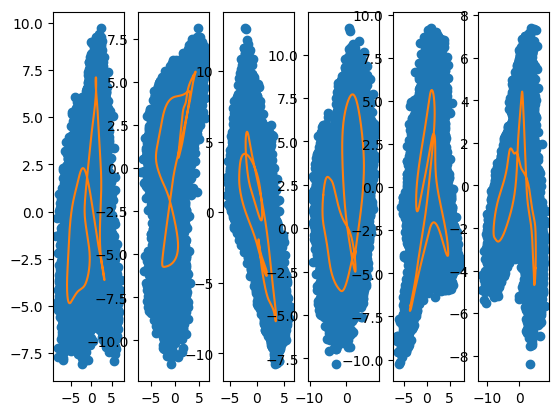

In [75]:
data_plot_density = 1
fig, axs = plt.subplots(ncols=n_projections)
for i in range(n_projections):
    axs[i].scatter(projected_data[::data_plot_density, i, 0], projected_data[::data_plot_density, i, 1], color="C0")
    axs[i].plot(projected_test_embedding[:, i, 0], projected_test_embedding[:, i, 1], color="C1")


These generally aren't that useful: if they were, PCA alone would probably be enough to reveal the ring structure.

Now compare to ground-truth head direction information

In [76]:
with torch.no_grad():
    decoded_points, decoded_angles = decoder(torch.tensor(normed_rates, dtype=torch.get_default_dtype()).to(device))

predicted_phases = torch.squeeze(decoded_angles).cpu().numpy()


In [77]:
def reference_phases(phases):
    phases_refd = phases - phases[0]
    phases_refd = np.arctan2(np.sin(phases_refd), np.cos(phases_refd))
    return phases_refd * np.sign(phases_refd[1])

def compare_to_ground_truth(predicted_phases, ground_truth_phases, plot_ax):
    refd_test_phases = reference_phases(predicted_phases)
    refd_true_phases = reference_phases(ground_truth_phases)
    line = np.arange(start=-np.pi, stop=np.pi, step=0.01)
    plot_ax.scatter(refd_true_phases, refd_test_phases)
    plot_ax.plot(line, line, color="black", linestyle="--", label="y=x")
    plot_ax.set_xlabel("True Phase")
    plot_ax.set_ylabel("Found Phase")
    return refd_test_phases, refd_true_phases


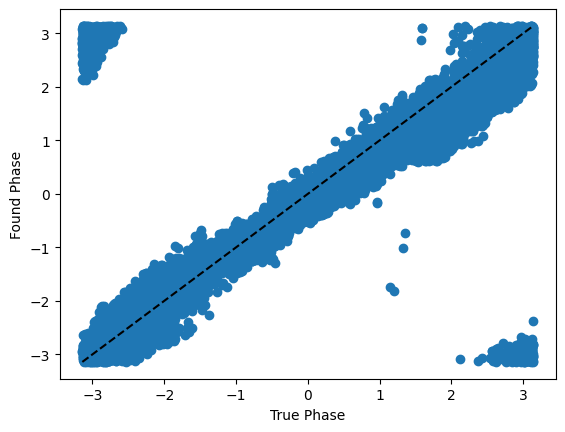

In [78]:
fig, axs = plt.subplots()
refd_pred, refd_data = compare_to_ground_truth(predicted_phases, angles, axs)


If the decoding worked, the data should be randomly and evenly distributed around the line y=x (or y=-x if the sign convention is detected incorrectly). If this is the case, the residual error is due to noise. Alternatively, in histogram form,

Text(0, 0.5, 'Counts')

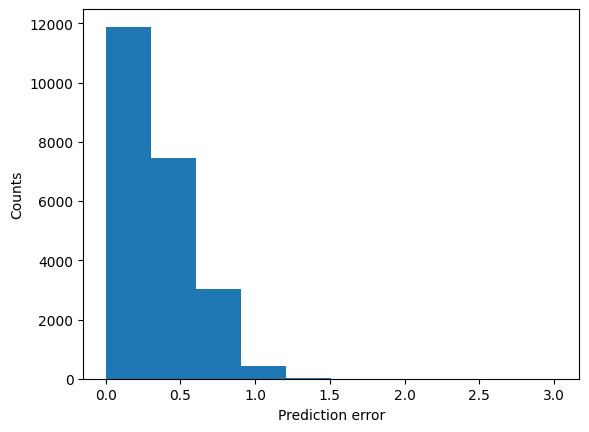

In [85]:
with torch.no_grad():
    errors, _, _ = geometry_util.minimum_periodic_distance(torch.Tensor(np.expand_dims(refd_pred, -1)), torch.Tensor(np.expand_dims(refd_data, -1)))
fig, axs = plt.subplots()
axs.hist(errors)
axs.set_xlabel("Prediction error")
axs.set_ylabel("Counts")
